In [9]:
import numpy as np
import rdkit
from mordred import Calculator, descriptors
from glob import glob
from rdkit import rdBase, Chem ,DataStructs
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import MolDrawing, DrawingOptions
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import rdFMCS
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import BRICS
from rdkit.Chem.Descriptors import NumValenceElectrons
from rdkit.Chem import Descriptors
from rdkit.Chem.rdMolDescriptors import GetUSRScore, GetUSRCAT
from rdkit.Avalon import pyAvalonTools
import pubchempy as pcp
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from rdkit.Chem import Recap
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import rdRGroupDecomposition as rdRGD
from rdkit.ML.Descriptors import MoleculeDescriptors
from sklearn.decomposition import PCA
import nglview
%matplotlib inline
 

In [10]:
#df = pd.read_csv("antibiotic_reproduction.csv")
df = pd.read_csv("reprod_total.csv")
datalist = df.values.tolist()
positive_smiles = [i[0] for i in datalist if i[1] == 1]
negative_smiles = [i[0] for i in datalist if i[1] == 0]
positive_mols = [Chem.MolFromSmiles(i) for i in positive_smiles]
negative_mols = [Chem.MolFromSmiles(i) for i in negative_smiles]
#df= pd.read_csv("drug_repurpose.csv",delimiter="/t")
df= pd.read_csv("zinc.csv")
pred_top99 = df.values.tolist()
pred_top99 = [pred_top99[i][0] for i in range(len(pred_top99))]
pred_top99_mols = [Chem.MolFromSmiles(i) for i in pred_top99]

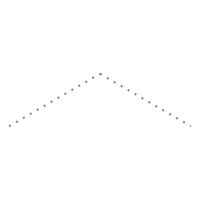

In [5]:
mcs_pos = rdFMCS.FindMCS(positive_mols)
mol_mcs_pos = Chem.MolFromSmarts(mcs_pos.smartsString)
Draw.MolsToGridImage([mol_mcs_pos],molsPerRow=1)

407
('[11*]Sc1nnnn1C', 8)
('[4*]CC1=C(C(=O)O)N2C(=O)C(N[5*])C2SC1', 7)
('[1*]C(=O)/C(=N\\OC)c1csc(N)n1', 7)
('[5*]N1CCNCC1', 6)
('[5*]N1CCN(C)CC1', 6)
('[16*]c1ccccc1', 5)
('[1*]C(=O)C(N[5*])C(C)O', 5)
('[1*]C(=O)C(=NOC)c1csc(N)n1', 5)
('[4*]Cc1ccccc1', 5)
('[4*]CC1=C(C(=O)O)N2C(=O)[C@@H](N[5*])[C@H]2SC1', 4)
('[9*]n1nnnc1S[11*]', 4)
('[4*]CC1=C(C(=O)[O-])N2C(=O)C(N[5*])C2SC1', 4)
('[5*][N+](C)(C)Cc1ccccc1', 4)
('[16*]c1c(F)cc2c(=O)c(C(=O)O)cn(C3CC3)c2c1OC', 3)
('[16*]c1cc2c(cc1F)c(=O)c(C(=O)O)cn2C1CC1', 3)
('[4*]C(C)(C)C(=O)O', 3)
('[1*]C(=O)Cc1cccs1', 3)
('[3*]OCOC(=O)C(C)(C)C', 3)
('[1*]C(=O)C(C)(C)C', 3)
('[16*]c1ccc(O)cc1', 3)


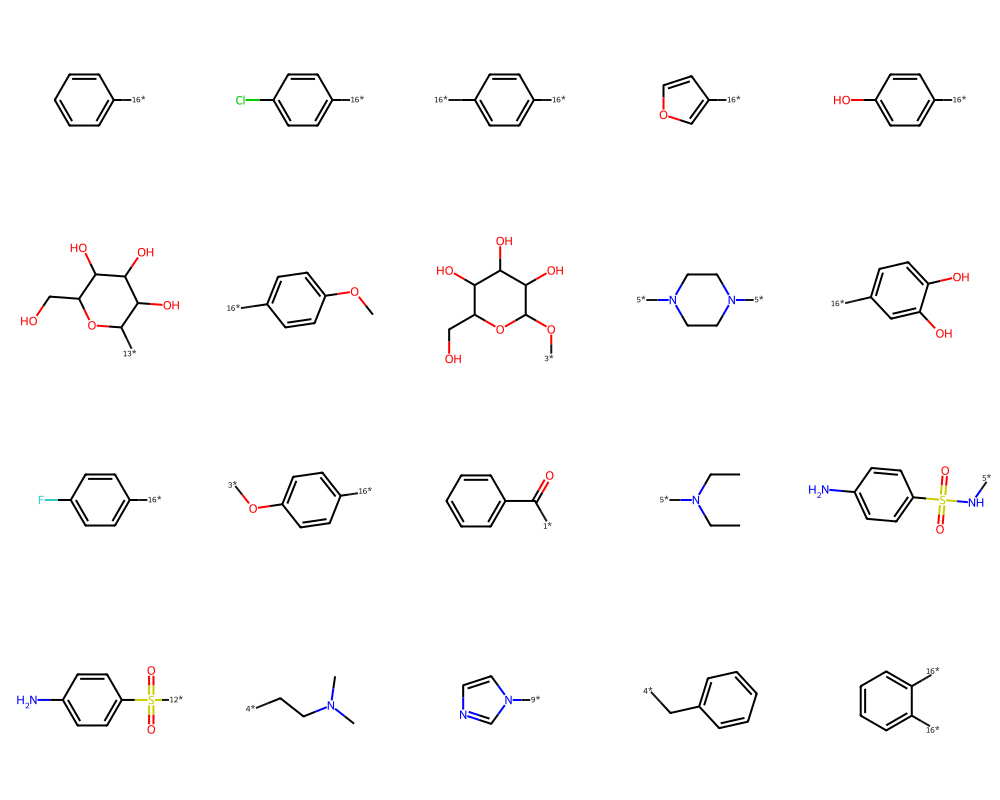

In [11]:
allfrags = {}
negative_allfrags ={}
pred_allfrags ={}
def fragment_recursive(mol, frags):
    #try:
        bonds = list(BRICS.FindBRICSBonds(mol))
        if len(bonds) == 0:
            frags.append(Chem.MolToSmiles(mol))
            return frags
        
        idxs, labs = list(zip(*bonds))
        # print(bonds)
        # print(idxs, labs)
        bond_idxs = []
        for a1, a2 in idxs:
            bond = mol.GetBondBetweenAtoms(a1, a2)
            bond_idxs.append(bond.GetIdx())
        order = np.argsort(bond_idxs).tolist()
        bond_idxs = [bond_idxs[i] for i in order]
        broken = Chem.FragmentOnBonds(mol,
                                      bondIndices=[bond_idxs[0]],
                                      dummyLabels=[(0, 0)])
        head,tail = Chem.GetMolFrags(broken, asMols=True)
        #print(mol_to_smiles(head), mol_to_smiles(tail))
        frags.append(Chem.MolToSmiles(head))
        return fragment_recursive(tail, [frags])
    #except Exception as e:
        #print (e)
        #pass
def remove_number(mol_smiles):
    ls=["[{}*]".format(i) for i in range(1,21)]
    for i in ls:
        if i in mol_smiles:
            mol_smiles=mol_smiles.replace(i,"[H]")
    return mol_smiles        


for mol in positive_mols:
    #pieces = fragment_recursive(mol,[])
    pieces = BRICS.BRICSDecompose(mol,minFragmentSize=5)
    #pieces=Recap.RecapDecompose(mol).GetLeaves().keys()
    #pieces=Recap.RecapDecompose(mol).GetAllChildren().keys()
    for piece in pieces: 
        #piece = remove_number(piece)
        allfrags[piece]=allfrags.get(piece,0) + 1

for mol in negative_mols:
    pieces = BRICS.BRICSDecompose(mol,minFragmentSize=5)
    for piece in pieces: 
        #piece = remove_number(piece)
        negative_allfrags[piece]=negative_allfrags.get(piece,0) + 1

for mol in pred_top99_mols:
    pieces = BRICS.BRICSDecompose(mol,minFragmentSize=5)
    for piece in pieces: 
        #piece = remove_number(piece)
        pred_allfrags[piece]=pred_allfrags.get(piece,0) + 1


allfrags_list = list(allfrags.items())
allfrags_list.sort(key=lambda x:x[1], reverse=True)

negative_allfrags_list = list(negative_allfrags.items())
negative_allfrags_list.sort(key=lambda x:x[1], reverse=True)

pred_allfrags_list = list(pred_allfrags.items())
pred_allfrags_list.sort(key=lambda x:x[1], reverse=True)

print(len(allfrags_list))
#print(len(negative_allfrags_list)
for i in range(20):
    print(allfrags_list[i])
frag_top20=[allfrags_list[i][0] for i in range(20)]
fragmol_top20=[Chem.MolFromSmiles(i) for i in frag_top20]

negative_frag_top20=[negative_allfrags_list[i][0] for i in range(20)]
negative_fragmol_top20=[Chem.MolFromSmiles(i) for i in negative_frag_top20]

pred_frag_top20=[pred_allfrags_list[i][0] for i in range(20)]
pred_fragmol_top20 =[Chem.MolFromSmiles(i) for i in pred_frag_top20]

Draw.MolsToGridImage(negative_fragmol_top20,molsPerRow=5)


Plotting 2D distribution map for fragments of positive , negative and predicted top molecules in primary dataset

In [12]:
des_list = [x[0] for x in Descriptors._descList]
calculator = MoleculeDescriptors.MolecularDescriptorCalculator(des_list)
calc = Calculator(descriptors)

def standardization(data):
    mu = np.mean(data, axis=0)
    sigma = np.std(data, axis=0)
    return (data - mu) / sigma


fps_pos_frg=np.array([AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(i[0]), 2, 2048) for i in allfrags_list])
fps_neg_frg=np.array([AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(i[0]), 2, 2048) for i in negative_allfrags_list])
fps_pre_frg=np.array([AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(i[0]), 2, 2048) for i in pred_allfrags_list])
fps_pos_top=np.array([AllChem.GetMorganFingerprintAsBitVect(mol,2,2048) for mol in  fragmol_top20])
fps_neg_top=np.array([AllChem.GetMorganFingerprintAsBitVect(mol,2,2048) for mol in  negative_fragmol_top20])
fps_pre_top=np.array([AllChem.GetMorganFingerprintAsBitVect(mol,2,2048) for mol in  pred_fragmol_top20])

#des_pos_frg=np.array([calculator.CalcDescriptors(Chem.MolFromSmiles(i[0])) for i in allfrags_list ])
#des_neg_frg=np.array([calculator.CalcDescriptors(Chem.MolFromSmiles(i[0])) for i in negative_allfrags_list ])
#des_pre_frg=np.array([calculator.CalcDescriptors(Chem.MolFromSmiles(i[0])) for i in pred_allfrags_list ])
#des_pos_top=np.array([calculator.CalcDescriptors(mol) for mol in fragmol_top20])
#des_neg_top=np.array([calculator.CalcDescriptors(mol) for mol in negative_fragmol_top20])
#des_pre_top=np.array([calculator.CalcDescriptors(mol) for mol in pred_fragmol_top20])

des_pos_frg=np.array([calc(Chem.MolFromSmiles(i[0]))[:] for i in allfrags_list ])
des_neg_frg=np.array([calc(Chem.MolFromSmiles(i[0]))[:] for i in negative_allfrags_list ])
des_pre_frg=np.array([calc(Chem.MolFromSmiles(i[0]))[:] for i in pred_allfrags_list ])
des_pos_top=np.array([calc(mol)[:] for mol in fragmol_top20])
des_neg_top=np.array([calc(mol)[:] for mol in negative_fragmol_top20])
des_pre_top=np.array([calc(mol)[:] for mol in pred_fragmol_top20])

pos_frg_fts =np.concatenate((fps_pos_frg,des_pos_frg),axis=1)
neg_frg_fts =np.concatenate((fps_neg_frg,des_neg_frg),axis=1)
pre_frg_fts =np.concatenate((fps_pre_frg,des_pre_frg),axis=1)
pos_top_fts =np.concatenate((fps_pos_top,des_pos_top),axis=1)
neg_top_fts =np.concatenate((fps_neg_top,des_neg_top),axis=1)
pre_top_fts =np.concatenate((fps_pre_top,des_pre_top),axis=1)

#pos_frg_fts=[fps_pos_frg[i]+des_pos_frg[i] for i in range(len(allfrags))]
#neg_frg_fts=[fps_neg_frg[i]+des_neg_frg[i] for i in range(len(negative_allfrags))]
#pre_frg_fts=[fps_pre_frg[i]+des_pre_frg[i] for i in range(len(pred_allfrags))]

print(pos_frg_fts.shape)
print(neg_frg_fts.shape)
print(pre_frg_fts.shape)
print(pos_top_fts.shape)
print(neg_top_fts.shape)
print(pre_top_fts.shape)

X= np.nan_to_num(np.concatenate((pos_frg_fts,neg_frg_fts,pre_frg_fts),axis=0),nan=0, posinf=0, neginf=0)
x_fps=np.nan_to_num(np.concatenate((fps_pos_frg,fps_neg_frg,fps_pre_frg),axis=0),nan=0, posinf=0, neginf=0)
x_des=np.nan_to_num(np.concatenate((des_pos_frg,des_neg_frg,des_pre_frg),axis=0),nan=0, posinf=0, neginf=0)


print(X.shape)
#X=np.nan_to_num(X,0)
pca1 = PCA(n_components=1)
pca1.fit(x_des)
pca2 =PCA(n_components=1)
pca2.fit(x_fps)
pca=PCA(n_components=1)
pca.fit(X)

fps_pos_frg=pca2.transform(np.nan_to_num(fps_pos_frg,nan=0, posinf=0, neginf=0))
des_pos_frg=pca1.transform(np.nan_to_num(des_pos_frg,nan=0, posinf=0, neginf=0))
fps_neg_frg=pca2.transform(np.nan_to_num(fps_neg_frg,nan=0, posinf=0, neginf=0))
des_neg_frg=pca1.transform(np.nan_to_num(des_neg_frg,nan=0, posinf=0, neginf=0))
fps_pre_frg=pca2.transform(np.nan_to_num(fps_pre_frg,nan=0, posinf=0, neginf=0))
des_pre_frg=pca1.transform(np.nan_to_num(des_pre_frg,nan=0, posinf=0, neginf=0))

fps_pos_top=pca2.transform(np.nan_to_num(fps_pos_top,nan=0, posinf=0, neginf=0))
des_pos_top=pca1.transform(np.nan_to_num(des_pos_top,nan=0, posinf=0, neginf=0))
fps_neg_top=pca2.transform(np.nan_to_num(fps_neg_top,nan=0, posinf=0, neginf=0))
des_neg_top=pca1.transform(np.nan_to_num(des_neg_top,nan=0, posinf=0, neginf=0))
fps_pre_top=pca2.transform(np.nan_to_num(fps_pre_top,nan=0, posinf=0, neginf=0))
des_pre_top=pca1.transform(np.nan_to_num(des_pre_top,nan=0, posinf=0, neginf=0))


print(pca1.explained_variance_ratio_)
print(pca2.explained_variance_ratio_)
print(pca.explained_variance_ratio_)
#df_pos = pd.DataFrame(pos_frg_fts,index=None,columns=["0","1"])
#df_neg = pd.DataFrame(neg_frg_fts,index=None,columns=["0","1"])
#df_pre = pd.DataFrame(pre_frg_fts,index=None,columns=["0","1"])
#df_pos_top =pd.DataFrame(pos_top_fts,index=None,columns=["0","1"])
#df_neg_top =pd.DataFrame(neg_top_fts,index=None,columns=["0","1"])
#df_pre_top =pd.DataFrame(pre_top_fts,index=None,columns=["0","1"])




/home/shxie/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(407, 3874)
(3606, 3874)
(5199, 3874)
(20, 3874)
(20, 3874)
(20, 3874)
(9212, 3874)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [14]:
x_des=np.nan_to_num(np.concatenate((des_pos_frg,des_neg_frg,des_pre_frg),axis=0),nan=0, posinf=0, neginf=0)
pca1.fit(x_des)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [31]:
#compute similarity
close_sim_total=0
for i in pred_fragmol_top20:
    target_fp=AllChem.GetMorganFingerprintAsBitVect(i,2, 2048)
    fp_list =[AllChem.GetMorganFingerprintAsBitVect(j,2, 2048) for j in fragmol_top20]
    sim_list=[DataStructs.TanimotoSimilarity(target_fp, mfp) for mfp in fp_list]
    close_sim_total+= max(sim_list)
close_sim_mean=close_sim_total/20
print(close_sim_mean)   
 

0.3220079041653808


(279, 1)
(279, 1)


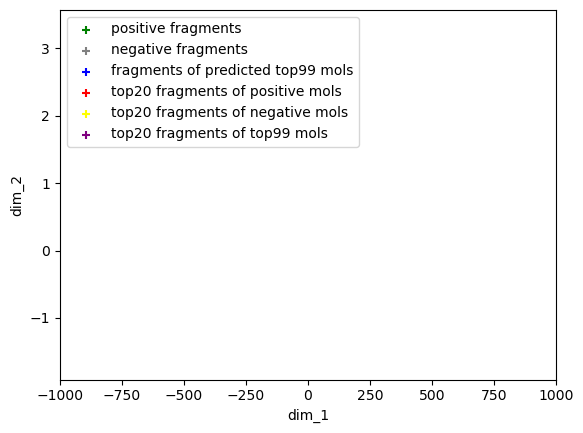

In [26]:
print(des_pos_frg.shape)
print(fps_pos_frg.shape)
plt.scatter(des_pos_frg, fps_pos_frg,c="green",marker="+",label="positive fragments")
plt.scatter(des_neg_frg, fps_neg_frg,c="gray",marker="+",label="negative fragments")
plt.scatter(des_pre_frg, fps_pre_frg,c="blue",marker="+",label="fragments of predicted top99 mols")
plt.scatter(des_pos_top, fps_pos_top,c="red",marker="+",label="top20 fragments of positive mols")
plt.scatter(des_neg_top, fps_neg_top,c="yellow",marker="+",label="top20 fragments of negative mols")
plt.scatter(des_pre_top, fps_pre_top,c="purple",marker="+",label="top20 fragments of top99 mols")
plt.xlabel('dim_1')
plt.ylabel('dim_2')
#plt.ylim(-2,4)
plt.xlim(-1000,1000)
plt.legend(loc=2)
plt.show()

In [85]:
#cluster by usrcat fingerprints
def ClusterFps(fps,cutoff=0.2):
    from rdkit import DataStructs
    from rdkit.ML.Cluster import Butina

    # first generate the distance matrix:
    dists = []
    nfps = len(fps)
    for i in range(1,nfps):
        sims = DataStructs.BulkTanimotoSimilarity(fps[i],fps[:i])
        dists.extend([1-x for x in sims])

    # now cluster the data:
    cs = Butina.ClusterData(dists,nfps,cutoff,isDistData=True)
    return cs

mols3d =[]
for mol in positive_mols:
    m2=Chem.AddHs(mol)
    AllChem.EmbedMolecule(m2,useRandomCoords=True)
    opt_state=AllChem.MMFFOptimizeMolecule(m2,maxIters=2000)
    mols3d.append(m2)
    
usrcats = [ GetUSRCAT( mol ) for mol in mols3d ]
import nglview
nglview.show_rdkit(mols3d[24])

[15:59:52] UFFTYPER: Unrecognized atom type: Zn1+2 (8)


NGLWidget()

((35, 31, 34, 36, 59, 60, 61, 71, 84), (6, 11, 14, 26, 48, 74, 76, 83, 88), (108, 93, 101, 104, 106, 107, 109), (8, 17, 40, 66, 69), (46, 0, 9, 19, 32, 41), (27, 13, 22, 55, 58), (115, 81, 113), (96, 2, 56), (65, 24, 50), (39, 28, 64), (37,), (7, 45, 91), (117, 100), (114,), (111,), (95, 29), (85, 20), (79,), (77,), (53, 47), (43, 38), (33,), (119,), (118,), (116,), (112,), (110,), (105,), (103,), (102,), (99,), (98,), (97,), (94,), (92,), (90,), (89,), (87,), (86,), (82,), (80,), (78,), (75,), (73,), (72,), (70,), (68,), (67,), (63,), (62,), (57,), (54,), (52,), (51,), (49,), (44,), (42,), (30,), (25,), (23,), (21,), (18,), (16,), (15,), (12,), (10,), (5,), (4,), (3,), (1,))


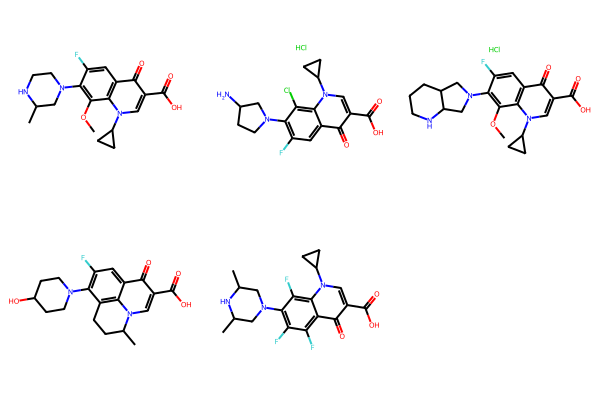

In [89]:
fps = [AllChem.GetMorganFingerprintAsBitVect(x,2,1024) for x in positive_mols]
clusters=ClusterFps(fps,cutoff=0.5)

print(clusters)
Draw.MolsToGridImage([positive_mols[i] for i in clusters[3]])

[16:49:34] No core matches
[16:49:34] No core matches


[('O[*:1]', 1), ('C[*:2]', 1), ('O=C(O)[*:3]', 1), ('O[*:4]', 1), ('C[*:5]', 1), ('NC[*:1]', 1), ('O=C(O)[*:2]', 1), ('F[*:3]', 1), ('CO[*:4]', 1), ('NCC[*:1]', 1), ('CC(C)C[*:2]', 1), ('NCC[*:3]', 1), ('NCC[*:4]', 1), ('CC(O)[*:5]', 1), ('CCC(C)CCCCC(=O)NC(CCN)C(=O)NC(C(=O)NC(CCN)C(=O)N[*:6])C(C)O', 1), ('N=C(N)[*:1]', 1), ('Cl[*:1]', 1), ('Cl[*:2]', 1), ('C[*:1]', 1), ('CCOC(=O)[*:2]', 1), ('O[*:3]', 1), ('O=C[*:4]', 1), ('O[*:5]', 1), ('N[*:1]', 1), ('CC(=O)OC[*:2]', 1), ('O=C([O-])[*:3]', 1), ('O=C(NC(CO)C(O)[*:1])C(Cl)Cl', 1), ('O=[N+]([O-])[*:2]', 1), ('O=C(O)[*:1]', 1), ('F[*:2]', 1), ('C[*:3]', 1), ('O=C([O-])[*:1]', 1), ('C[*:1].O[*:1]', 1), ('C[*:10]', 1), ('C[*:11]', 1), ('O[*:12]', 1), ('CO[*:13].C[*:13]', 1), ('C[*:14]', 1), ('CC[*:15]', 1), ('O[*:2]', 1), ('C[*:4]', 1), ('C[*:6].O[*:6]', 1), ('O[*:7]', 1), ('CN(C)[*:8]', 1), ('C[*:9]', 1), ('CN[*:10]', 1), ('N[*:3]', 1), ('CC(O)[*:6]', 1), ('N[*:7]', 1), ('N[*:8]', 1), ('O[*:9]', 1), ('N[*:4]', 1), ('O=S(=O)([O-])C[*:2]',

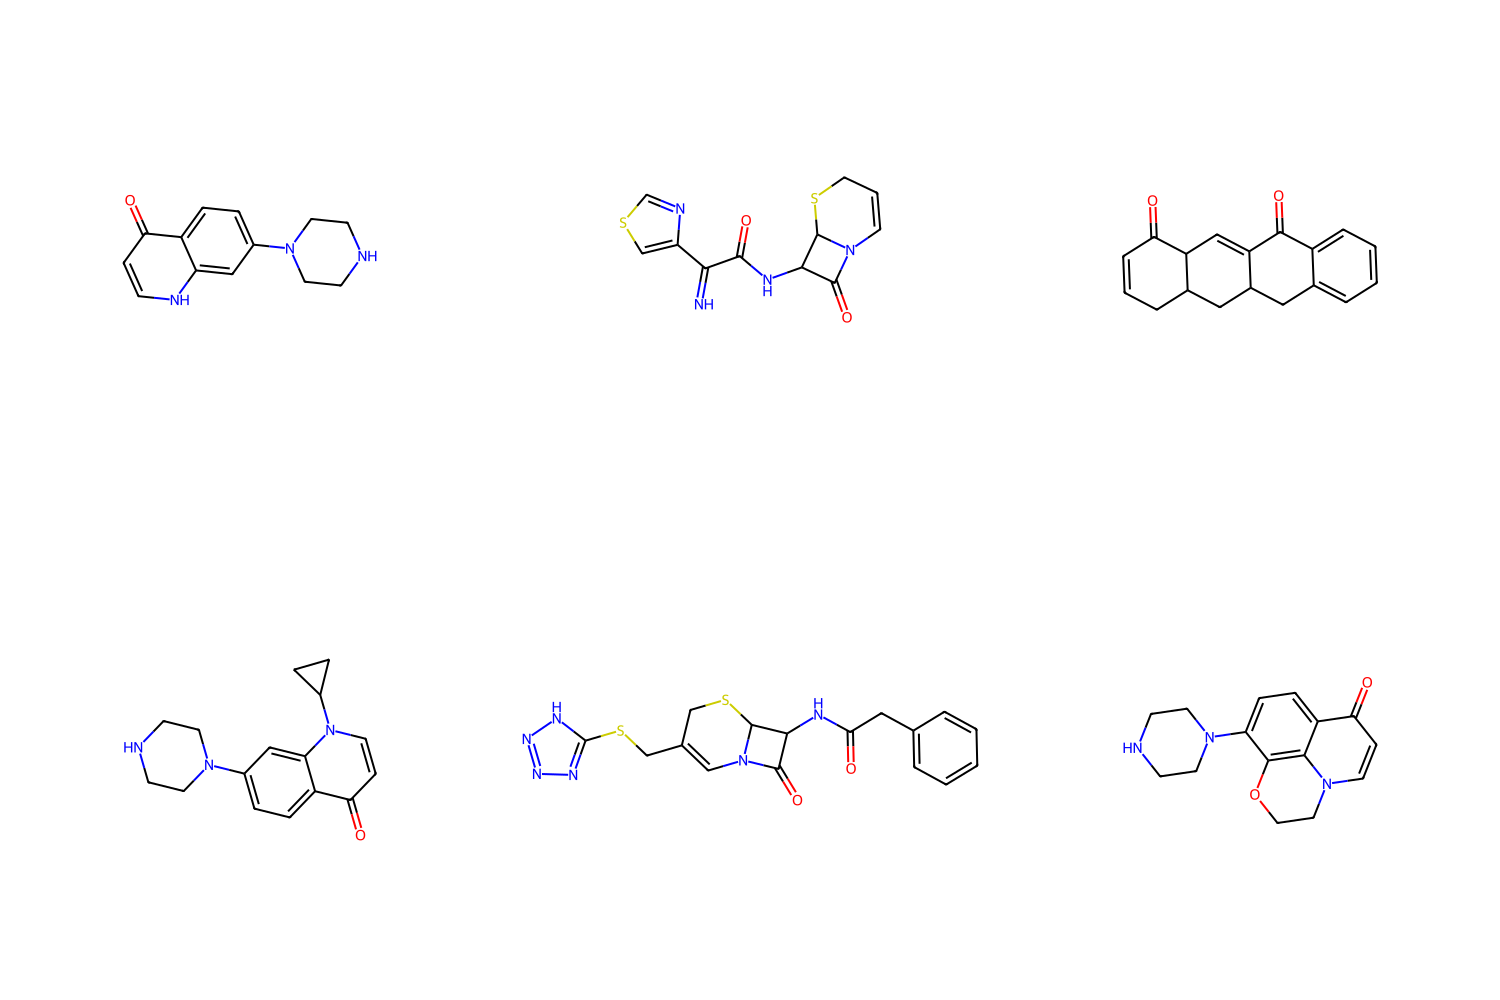

In [97]:
#scaffold_extract
pos_atomic_scaffolds = [MurckoScaffold.GetScaffoldForMol(mol) for mol in positive_mols]
for i in pos_atomic_scaffolds:
    i.Compute2DCoords()

def genericize_scaffold(s):
    try:
        return MurckoScaffold.MakeScaffoldGeneric(s)
    except ValueError:
        return None
pos_graph_scaffolds = [genericize_scaffold(s) for s in pos_atomic_scaffolds]
#len(positive_mols), len(drugbank_atomic_scaffolds), len(drugbank_graph_scaffolds), len([x for x in drugbank_graph_scaffolds if x == None])
#Draw.MolsToGridImage([positive_mols[111], pos_atomic_scaffolds[111], pos_graph_scaffolds[111]])

R_group={}
scaffolds={}
for mol in positive_mols:
    core=MurckoScaffold.GetScaffoldForMol(mol)
    core_smiles=Chem.MolToSmiles(core) 
    res,unmatched =rdRGD.RGroupDecompose([core],[mol],asSmiles=True)
    if res:
        for i in res[0].items():
            if i[0] == "Core":
                scaffolds[i[1]]=scaffolds.get(i[1],0)+1
            else:
                R_group[i[1]] = scaffolds.get(i[1],0) +1
R_group_list=list(R_group.items())
scaffolds_list=list(scaffolds.items())
R_group_list.sort(key=lambda x:x[1], reverse=True)
scaffolds_list.sort(key=lambda x:x[1], reverse=True)
print(R_group_list)
print(scaffolds_list)
R_group_top10=[Chem.MolFromSmiles(R_group_list[i][0]) for i in range(10)]
scaffolds_top10=[Chem.MolFromSmiles(scaffolds_list[i][0]) for i in range(10)]

Draw.MolsToGridImage(scaffolds_top10,molsPerRow=10)

scaffolds_cluster = [pos_atomic_scaffolds[i] for i in clusters[0]]
fp_cluster1 = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, 2048) for mol in scaffolds_cluster]
scaffolds_from_top6_clusters=[]
for i in range(6):
    scaffolds_cluster=[pos_atomic_scaffolds[k] for k in clusters[i]]
    fps_cluster = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, 2048) for mol in scaffolds_cluster]
    sim_list=[]
    for j in range(len(fps_cluster)):
        sim=0
        for l in range(len(fps_cluster)):
            if l == j:
                continue
            else:
                sim+=DataStructs.TanimotoSimilarity(fps_cluster[j],fps_cluster[l])
        sim_list.append([j,sim])
    sim_list.sort(key=lambda elemant:elemant[1],reverse=True)
    scaffolds_from_top6_clusters.append(scaffolds_cluster[sim_list[0][0]])

Draw.MolsToGridImage(scaffolds_from_top6_clusters,subImgSize=(500,500))
    




In [32]:
import random
random.seed(550)
print(type(fragmol_top20))
print(type(fragmol_top20[1]))
#fragms = [Chem.MolFromSmiles(x) for x in frag_top20]
fragms=fragmol_top20
ms = BRICS.BRICSBuild(fragms)
prods = [next(ms) for x in range(100)]
[prod.UpdatePropertyCache(strict=False) for prod in prods]
prods_smiles = [Chem.MolToSmiles(i) for i in prods]
df =pd.DataFrame(prods_smiles)
df.to_csv("/home/shxie/aiddsummary/antibio_reproduction/combine_smiles.csv",index=0)
#Draw.MolsToGridImage(prods,molsPerRow=5)

<class 'list'>
<class 'rdkit.Chem.rdchem.Mol'>


In [110]:
Chem.Draw.MolsToGridImage(prods, molsPerRow=4, subImgSize=(200, 200))

NameError: name 'prods' is not defined

In [80]:
#combine
combine_smiles=["CC(=O)N1CCN(C2=CC(O)=C3C(=O)C=C(C4CC4)NC3=C2)CC1","N=C(C(=O)C(O)C1C(=O)N2C(N3CCN(C4CC4)CC3)=CCSC12)C1=CSC=N1","",
                ]

[]